### Make neccessary imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras_core as keras
import tensorflow as tf
import keras_cv

import glob

Using TensorFlow backend


2023-11-08 06:02:25.589231: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 06:02:25.589316: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 06:02:25.592199: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-08 06:02:25.787819: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/kael/miniconda3/envs/DL/lib/python3.10/site-

In [2]:
# Project is structured as /train/<age>/image.jpg, /test/<age>/image.jpg
image_df = pd.DataFrame(glob.glob("./data/*/*/*"))
image_df = image_df[0].str.split("/").apply(lambda x: x[-3:])
image_df = pd.DataFrame(image_df.tolist(), columns=['split', 'age_group', 'filename'])
image_df['filepath'] = "./data/" + image_df['split'] + "/" + image_df['age_group'] + "/" + image_df['filename']
image_df.head(5)

split age_group    filename                     filepath
0  train       012   96445.jpg   ./data/train/012/96445.jpg
1  train       012   43925.jpg   ./data/train/012/43925.jpg
2  train       012  167879.jpg  ./data/train/012/167879.jpg
3  train       012    5899.jpg    ./data/train/012/5899.jpg
4  train       012   61557.jpg   ./data/train/012/61557.jpg

In [3]:
# How many age groups available for training across train / test split
print(image_df.groupby("split")['age_group'].nunique())

# Images available for training across train / test
print (image_df.groupby(["split"])['filename'].count())

split
test     100
train    100
Name: age_group, dtype: int64
split
test      47568
train    185632
Name: filename, dtype: int64


In [4]:
temp = image_df.groupby(['split', 'age_group'], as_index=False)['filename'].count()
temp = temp.rename({"filename": "file_count"}, axis=1)

# Average data available across each age group
temp.groupby("split")['file_count'].agg(['max', 'min', 'mean'])

max  min     mean
split                    
test   1592    1   475.68
train  6790    3  1856.32

In [5]:
# instances where there are very little training data available
temp[(temp['file_count'] < 20) & (temp['split'] == 'train')]

split age_group  file_count
193  train       094          18
194  train       095          13
196  train       097           8
197  train       098           3
198  train       099           6
199  train       100          13

### Visualize how the training images look

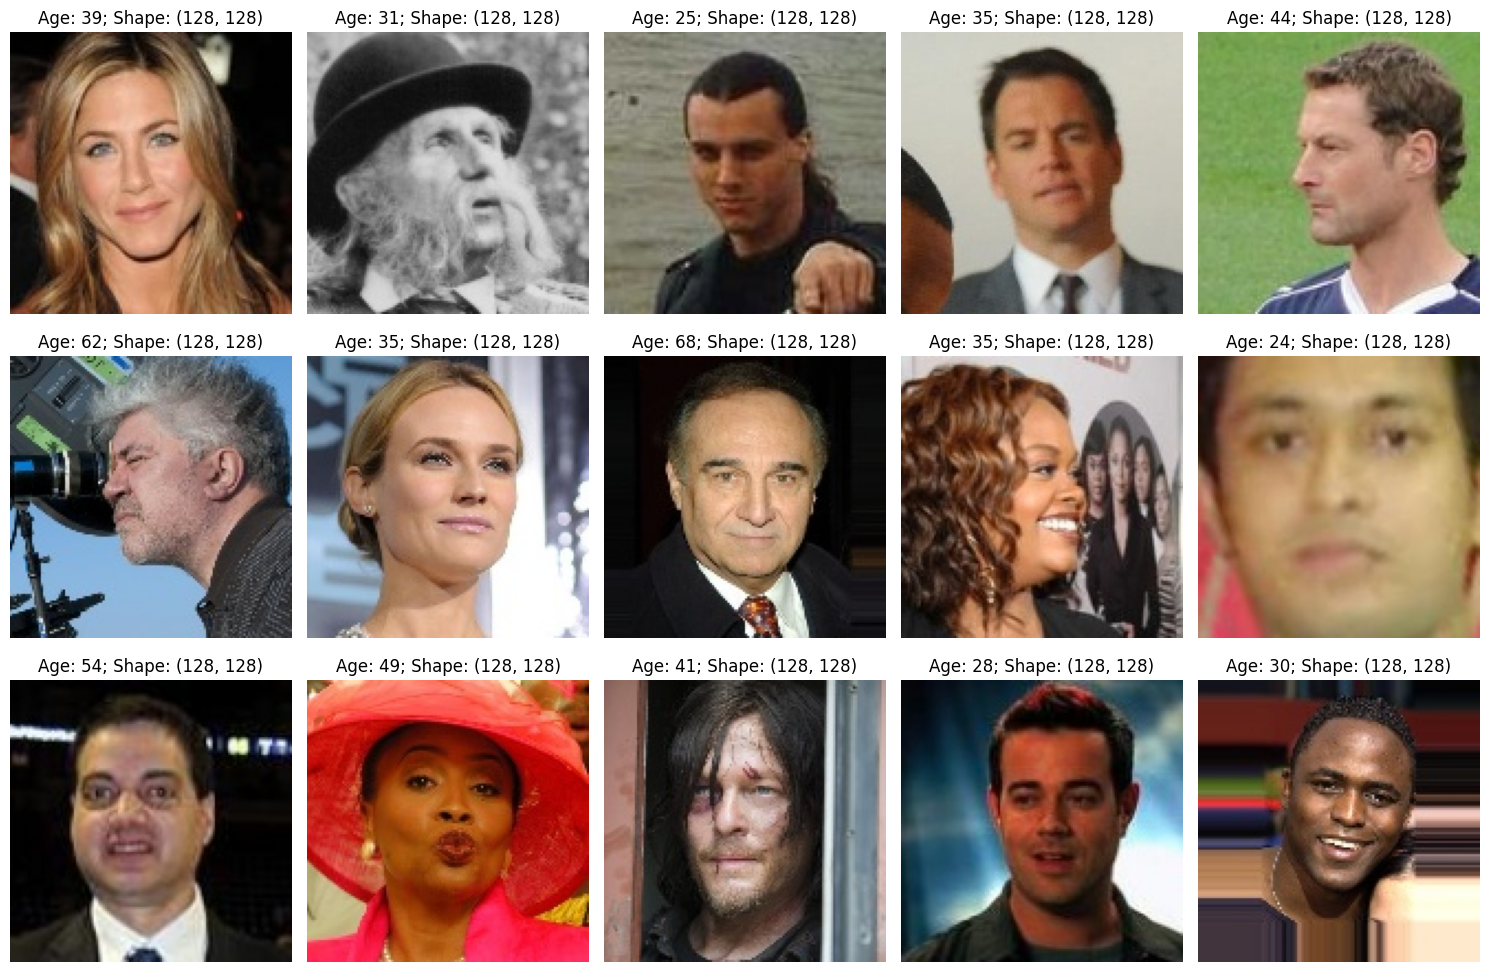

In [6]:
temp = image_df[image_df['split'] == 'train'].sample(15)

f, ax = plt.subplots(ncols=5, nrows=3, figsize=(15, 10))
ax = ax.ravel()

for i, row in enumerate(temp.itertuples()):
    img = keras.utils.load_img(row[-1])
    ax[i].imshow(img)
    ax[i].set_title(f'Age: {int(row[2])}; Shape: {img.size}')
    ax[i].axis('off')

plt.tight_layout();

### Creating a keras_cv augumentation layer

In [51]:
with tf.device("CPU"):
    augmenter = keras_cv.layers.RandomAugmentationPipeline(
        layers=[
            keras_cv.layers.RandomFlip(),
            keras_cv.layers.RandomContrast(value_range=(0, 1), factor=0.1),
            keras_cv.layers.RandomZoom(height_factor=(-0.1, 0.1)),
            keras_cv.layers.RandomBrightness(value_range=(0, 1), factor=0.2),
            keras_cv.layers.RandomRotation(0.1),
        ],
        augmentations_per_image=3,
    )

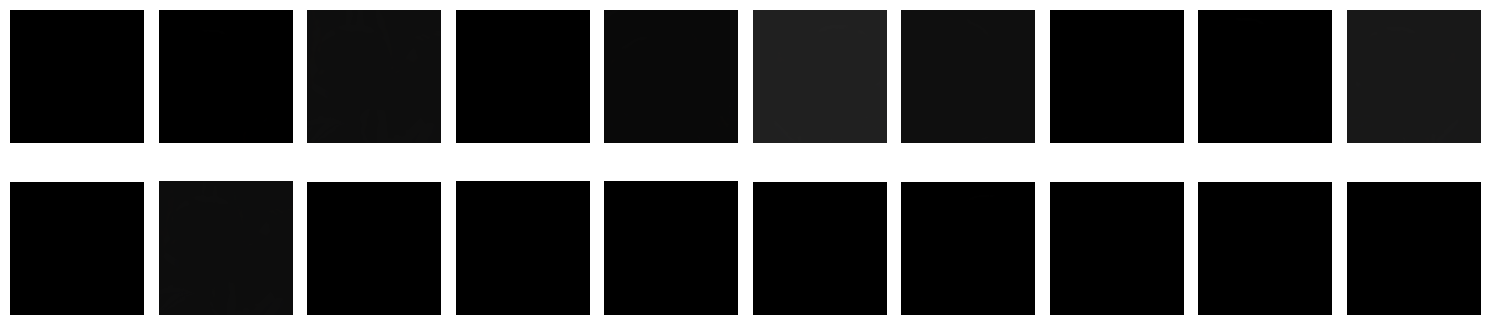

In [52]:
f, ax = plt.subplots(ncols=10, nrows=2, figsize=(15, 4))
ax = ax.ravel()

for i in range(20):
    ax[i].imshow(augmenter(np.array(img) / 255))
    ax[i].axis('off')

plt.tight_layout();

In [53]:
def create_dataset(filepaths, shuffle=False, augmenter=None, batch_size=32):

    if shuffle:
        filepaths = filepaths.sample(frac=1)
        
    temp: tf.data.Dataset = tf.data.Dataset.from_tensor_slices(filepaths)

    temp = temp.map(lambda x: (
        tf.image.resize(tf.image.decode_image(tf.io.read_file(x), channels=3, dtype='float32', expand_animations=False), size=(128, 128)),
        tf.strings.to_number(tf.strings.split(x, "/")[-2])
    ), num_parallel_calls=tf.data.AUTOTUNE)
    
    temp = temp.map(lambda x, y: (tf.ensure_shape(x, (128, 128, 3)), y))
    temp = temp.batch(batch_size)
        
    if augmenter:
        temp = temp.map(lambda x, y: (augmenter(x), y), tf.data.AUTOTUNE)

    temp = temp.prefetch(tf.data.AUTOTUNE)
    return temp

In [10]:
with tf.device("CPU"):
    train_ds = create_dataset(image_df.loc[image_df['split'] == 'train', 'filepath'], shuffle=True, augmenter=None)
    val_ds = create_dataset(image_df.loc[image_df['split'] == 'test', 'filepath'], shuffle=True, augmenter=None)

CPU times: user 611 ms, sys: 197 ms, total: 807 ms
Wall time: 554 ms


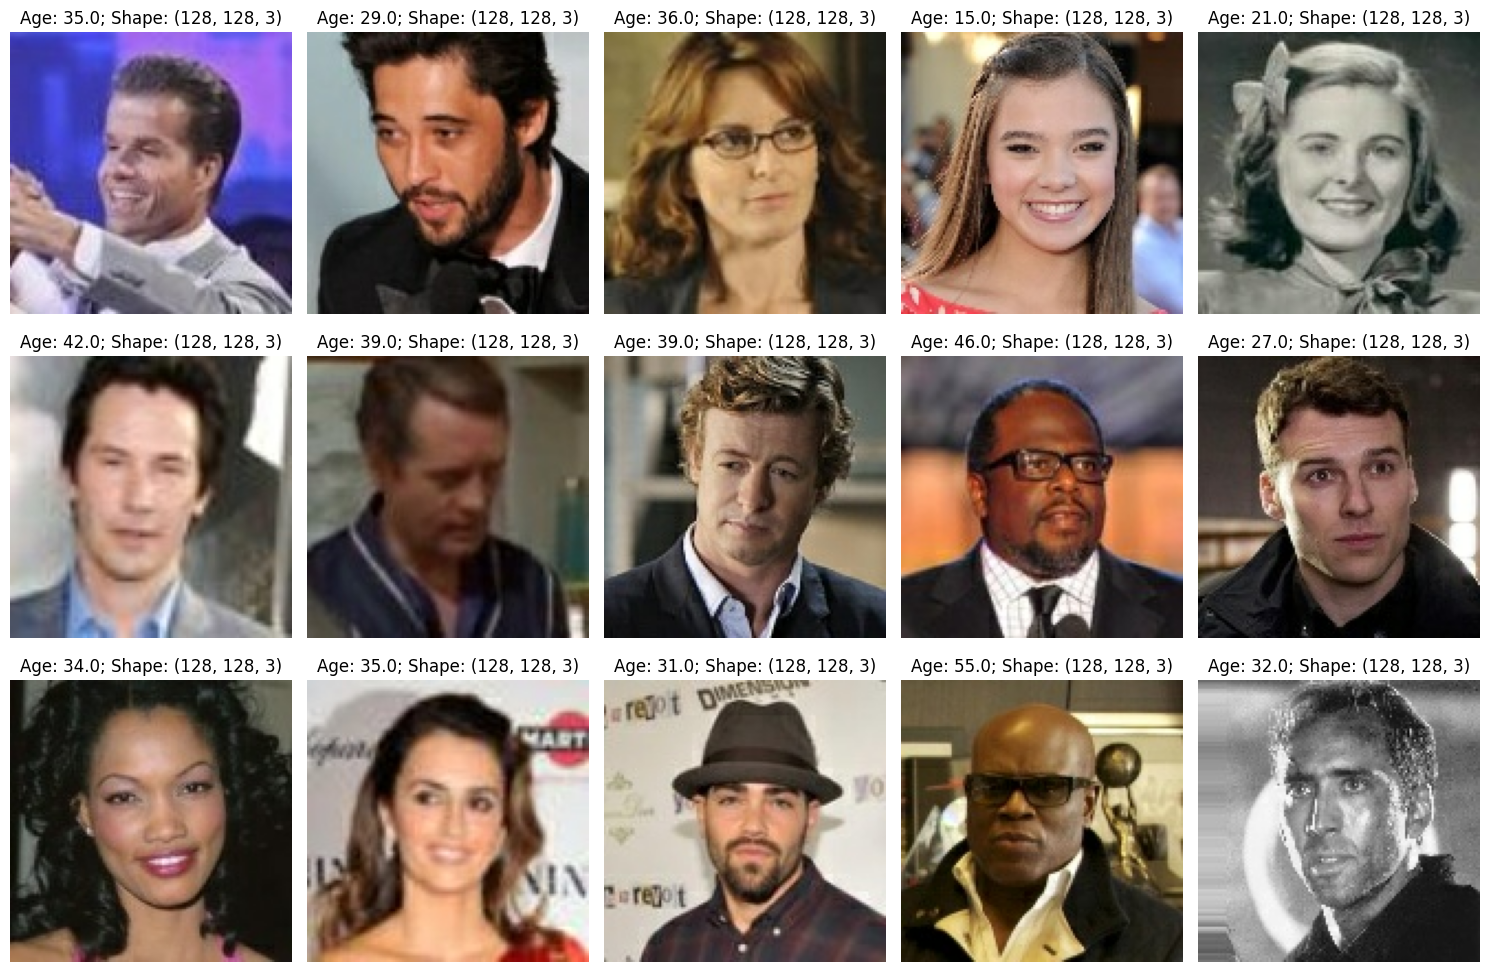

In [11]:
%%time
temp = list(train_ds.unbatch().take(15))

f, ax = plt.subplots(ncols=5, nrows=3, figsize=(15, 10))
ax = ax.ravel()

for i, (img, age) in enumerate(temp):
    ax[i].imshow(img)
    ax[i].set_title(f'Age: {age}; Shape: {img.shape}')
    ax[i].axis('off')

plt.tight_layout();

### Instead of creating a classification model, let us create a regression model and see how well it can perform

In [12]:
def get_model(mode='regression'):

    base_model = keras.applications.MobileNetV3Small(include_top=False, include_preprocessing=False, input_shape=(128, 128, 3))
    base_model.trainable = False
    
    input_ = keras.layers.Input(shape=(128, 128, 3))
    global_pool_layer = keras.layers.GlobalAvgPool2D()
    dense = keras.layers.Dense(units=32, activation='relu')

    if mode == 'classification':
        output_layer = keras.layers.Dense(units=100, activation='softmax')
    else:
        output_layer = keras.layers.Dense(1, activation='relu')

    x = input_
    x = base_model(x, training=False)
    x = global_pool_layer(x)
    x = dense(x)
    output_ = output_layer(x)

    model = keras.models.Model(inputs=input_, outputs=output_)

    if mode == 'classification':
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    else:
        model.compile(loss='mse', optimizer='adam')
    
    return model

In [13]:
model = get_model()
model.summary()

/home/kael/miniconda3/envs/DL/lib/python3.10/site-packages/keras_core/src/applications/mobilenet_v3.py:446: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ MobilenetV3small (Functional)   │ (None, 4, 4, 576)         │    939,120 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d        │ (None, 576)               │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 32)                │     18,464 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 1)                 │         33 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 957,617 (3.65 MB)

 Trainable params: 18,497 (72.25 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [14]:
# Try to save and load model, faced issues with having an input_layer + MobileNet inside Keras Sequential
model.save("test.keras")
keras.models.load_model("test.keras")
! rm test.keras

/bin/bash: /home/kael/miniconda3/envs/DL/lib/python3.10/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)


/home/kael/miniconda3/envs/DL/lib/python3.10/site-packages/keras_core/src/saving/saving_lib.py:347: UserWarning: Skipping variable loading for optimizer 'adam', because it has 286 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Epoch 1/3


2023-11-08 06:02:57.215015: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fea1c0067d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-08 06:02:57.215118: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-11-08 06:02:57.385485: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-08 06:03:00.127045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905


   7/5801 ━━━━━━━━━━━━━━━━━━━━ 2:06 22ms/step - loss: 1367.4247  

2023-11-08 06:03:08.729932: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5801/5801 ━━━━━━━━━━━━━━━━━━━━ 110s 16ms/step - loss: 215.4822 - val_loss: 151.7504
Epoch 2/3
5801/5801 ━━━━━━━━━━━━━━━━━━━━ 103s 18ms/step - loss: 147.6738 - val_loss: 146.2961
Epoch 3/3
5801/5801 ━━━━━━━━━━━━━━━━━━━━ 101s 17ms/step - loss: 143.2676 - val_loss: 144.1891


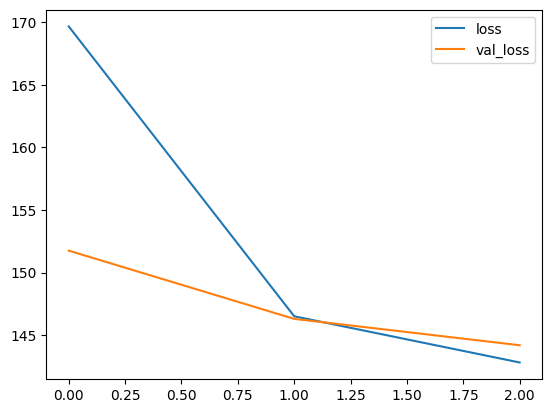

In [15]:
hist = model.fit(train_ds, validation_data=val_ds, epochs=3)
pd.DataFrame(hist.history, index=hist.epoch).plot();

In [25]:
model.save("./age_detection.keras")

### Model validation

In [46]:
model = keras.models.load_model("./age_detection.keras")

/home/kael/miniconda3/envs/DL/lib/python3.10/site-packages/keras_core/src/saving/saving_lib.py:347: UserWarning: Skipping variable loading for optimizer 'adam', because it has 286 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


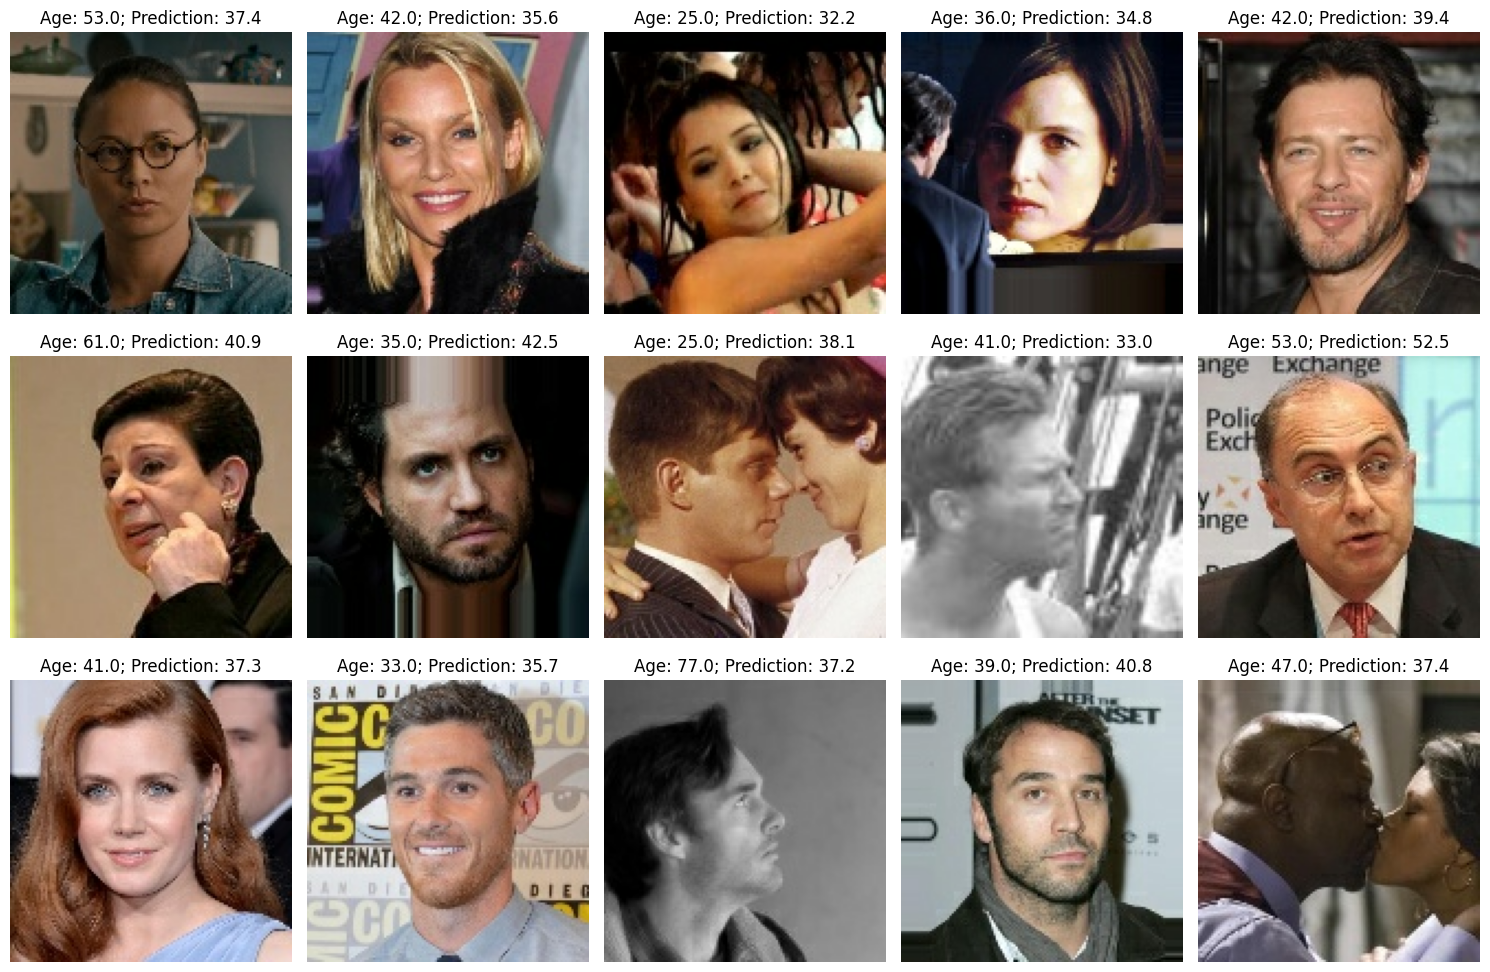

In [47]:
temp = list(val_ds.unbatch().shuffle(1000).take(15))

f, ax = plt.subplots(ncols=5, nrows=3, figsize=(15, 10))
ax = ax.ravel()

for i, (img, age) in enumerate(temp):
    pred = str(round(model.predict(keras.ops.expand_dims(img, axis=0), verbose=False)[0][0], 1))
    ax[i].imshow(img)
    ax[i].set_title(f'Age: {age}; Prediction: {pred}')
    ax[i].axis('off')

plt.tight_layout();

### Convert to a TFLite model:

In [48]:
# Export the model
export_path = 'age_detection_saved_model'
export_archive = keras.export.ExportArchive()
export_archive.add_endpoint(
    name="serve",
    fn=model.call,
    input_signature=[tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32)],
)
export_archive.write_out(export_path)

# Convert the saved model using TFLiteConverter
converter = tf.lite.TFLiteConverter.from_saved_model(export_path)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
tflite_model = converter.convert()

# Save the model.
with open('age_detection.tflite', 'wb') as f:
  f.write(tflite_model)

print ("Tflite Model saved to path: ./age_detection.tflite")

INFO:tensorflow:Assets written to: age_detection_saved_model/assets


INFO:tensorflow:Assets written to: age_detection_saved_model/assets


Saved artifact at 'age_detection_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    inputs: float32 Tensor, shape=(None, 128, 128, 3)
  Returns:
    float32 Tensor, shape=(None, 1)
Tflite Model saved to path: ./age_detection.tflite


2023-11-08 06:32:10.357597: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-11-08 06:32:10.357686: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-11-08 06:32:10.357893: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: age_detection_saved_model
2023-11-08 06:32:10.363147: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-11-08 06:32:10.363192: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: age_detection_saved_model
2023-11-08 06:32:10.379101: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-11-08 06:32:10.711258: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: age_detection_saved_model
2023-11-08 06:32:10.829171: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status

#### Sample TFLite model inference

In [49]:
# Load TFLite model and allocate tensors.
with open("./age_detection.tflite", 'rb') as f:
    tflite_model = f.read()

# Load the tflite model, allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Print the signatures
signatures = interpreter.get_signature_list()
print(signatures)

{'serving_default': {'inputs': ['inputs'], 'outputs': ['output_0']}}


In [50]:
temp = np.array(keras.preprocessing.image.load_img("sample.jpg", target_size=(128, 128))) / 255
temp = keras.ops.expand_dims(temp, axis=0)
temp = keras.ops.cast(temp, dtype='float32')

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

interpreter.set_tensor(input_index, temp)
interpreter.invoke()

# Compare TF Lite predictions with our actual model
print (interpreter.get_tensor(output_index), model.predict(temp, verbose=False))

[[35.11995]] [[35.120087]]
